<center> <h1> Pairs Trading Selection </h1> </center> 
<center> <h3> Sabina Lenskaya </h3> </center> 

## Motivation


In 2017 the equity markets, especially in the US, were unusually calm. The volatility index VIX, colloquially known as the **"fear index"** has dropped below **10**, which is almost twice lower than the markets have been experiencing on average within the past decade.

While one would expect that less fear is better, it does not hold true for traders. The lower the volatility on the market, the less extreme are the swings in prices. Therefore, there are not many opportunities to make money. 

Thus, traders need to consider other strategies in to make money, potentially market-neutral strategies.

## What is pairs trading?

In this project, I will consider so called <b>Pairs Trading</b> strategy. It is a market-neutral strategy that is created by going long an "underperforming" stock and short an "over-performing" stock in a specific industry. That said, the investor will screen the universe for the most correlated stocks to choose the pair and implement the strategy when this correlation weakens. 

The investor with such position will earn money due to the price differential, while being neutral to the direction of the move of the prices.


## Project Statement
In this Project I will examine the *Health Care* stocks universe that trade on NASDAQ to identify the relevant pairs that would be best used for the market-neutral (beta-hedged) Pairs Trading strategy.
The goal of this code is to scarp the data and slice the universe of the stocks based on the availability and quality of daily trading data. Then, statistical analysis or correlations will be used to systematically find the best pair of stocks that exhibit the necessary attributes. 

Based on the results of this exercise it would be possible to compare the returns on this strategy to the returns on the other possible portfolios that include the selected stocks. This way, the profitability of this trade over the sample period of time will be assessed. 


## Packages

* pandas_datareder will allow me to scrap the relevant data
* datetime package that will allow to select the dates appropriately
* pandas, numpy, statsmodels and sklearn are core for the data manipulation and analysis
* matplotlib is essential for plotting
* warnings - suppresses other package warnings to make it look neater

In [2]:
from pandas_datareader import DataReader #???
from pandas_datareader import data #???
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import datetime as dt
import numpy as np
# import quandl as qd
import matplotlib.pyplot as plt
% matplotlib inline

import statsmodels as st
from statsmodels.tsa.stattools import coint
# import statsmodels.api as sm     

# Instead use sklearn for linear regression
import sklearn.linear_model as lm


## Data Sources

Classical Pairs Trading selects the stocks within the same sector or industry. So I will be using NASDAQ-traded stocks universe to select the relevant pairs within the Health Care Sector.

To come up with this stock list, I will be using the csv file from the official NASDAQ website:

[NASDAQ Stocks](http://www.nasdaq.com/screening/companies-by-industry.aspx?exchange=NASDAQ)

For this project, all historical prices for each of the tickers are retrieved from Yahoo Finance.


In [3]:
nasdaq_comps = pd.read_csv("C:\\Users\\Xelor\\Desktop\\companylist.csv")
# this database classifies NASDAQ-traded stocks 

need_cols = ['Symbol', 'Sector', 'Industry', 'MarketCap'] 
# select the relevant columns for further analysis

nasdaq_comps = nasdaq_comps[need_cols]
nasdaq_comps.head(3)


,Symbol,Sector,Industry,MarketCap
0,PIH,Finance,Property-Casualty Insurers,4.368939e+07
1,TURN,Finance,Finance/Investors Services,6.317677e+07
2,FLWS,Consumer Services,Other Specialty Stores,7.270252e+08



Then, using this same stock list, it is necessary to ensure that our trades will not move the market significantly in case we would like to implement them at a large scale. 


This is why we select **Mid cap** to **Large cap** stocks - with a market cap **above 2B dollars**. 


In [4]:
nasdaq_comps_select = nasdaq_comps[(nasdaq_comps['Sector'] == 'Health Care') # Select Health Care Sector
                            & (nasdaq_comps['MarketCap'] > 2000000000.00)]  # Select MC above $2B.

print(nasdaq_comps_select.shape)
nasdaq_comps_select.head(3)

(85, 4)


,Symbol,Sector,Industry,MarketCap
17,ABMD,Health Care,Medical/Dental Instruments,8.404163e+09
23,ACHC,Health Care,Medical Specialities,2.799016e+09
24,ACAD,Health Care,Major Pharmaceuticals,3.529924e+09


In [5]:
pct_sel = 100*(nasdaq_comps_select.shape[0]/nasdaq_comps[(nasdaq_comps['Sector'] == 'Health Care')].shape[0])

print("We have selected "+str(pct_sel)+"% of Health Care stocks to analyze")

We have selected 12.686567164179104% of Health Care stocks to analyze


Thus, in total we have **85 Health Care** stocks trading in NASDAQ that have a Market Cap of more than 2B dollars.

We'll get them to a list, which later will be used to retreive their daily trading data.



In [6]:
ticks = nasdaq_comps_select['Symbol'].tolist()
print(ticks) # These are the tickers of the selected 85 Health Care companies

['ABMD', 'ACHC', 'ACAD', 'AAAP', 'AERI', 'AGIO', 'AKRX', 'ALXN', 'ALGN', 'ALKS', 'ALNY', 'AMGN', 'FOLD', 'ANAB', 'ARRY', 'AVXS', 'BGNE', 'BIIB', 'BMRN', 'TECH', 'BIVV', 'BLUE', 'BPMC', 'CELG', 'CBPO', 'CLVS', 'XRAY', 'DXCM', 'EXAS', 'EXEL', 'ESRX', 'FGEN', 'FMI', 'GILD', 'GRFS', 'GWPH', 'HALO', 'HCSG', 'HSIC', 'HOLX', 'HZNP', 'ICLR', 'ICUI', 'IDXX', 'IMMU', 'INCR', 'INCY', 'INGN', 'INSM', 'PODD', 'ISRG', 'IONS', 'IRWD', 'JAZZ', 'JUNO', 'LGND', 'LIVN', 'LOXO', 'MGLN', 'MASI', 'MMSI', 'MYL', 'MYGN', 'EYE', 'NKTR', 'NEOG', 'NBIX', 'NUVA', 'OPK', 'PDCO', 'PTLA', 'PRAH', 'PBYI', 'QGEN', 'REGN', 'SAGE', 'SRPT', 'SGEN', 'SHPG', 'SPPI', 'TSRO', 'UTHR', 'VRTX', 'WBA', 'WMGI']


Now that we have the necessary tickers, we will proceed to retreive the **daily trading data** from **Yahoo!** using DataReader. 

We use the **sample period of 3 years**, otherwise we run into a risk of having too many stocks that were not trading during longer time horizons.

Thus, we will look at all the data starting from <font color=red>**December 10th 2014 through December 10th 2017**</font>.

As an <font color=red>**example**</font>, we will retrive data and create a Time Series plot for the very first ticker on in our **ticks** list.


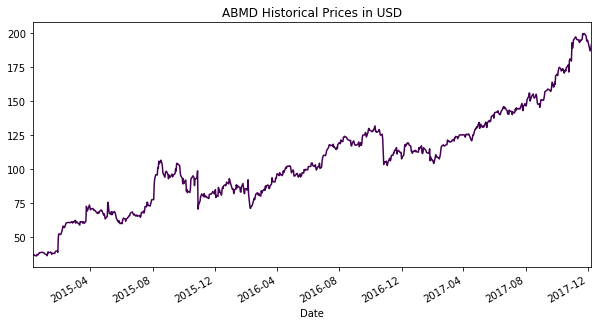

In [7]:
start = dt.datetime(2014, 12, 10)
end = dt.datetime(2017, 12, 10)
source = 'yahoo'

TS1_example = DataReader(ticks[0], 'yahoo', start, end)[['Close']]
TS1_example.plot(figsize = (10, 5), title = str(ticks[0])+ " Historical Prices in USD", legend=False, colormap = 'viridis')


Similarly, we are going to create a **table** of all Historical Closing Prices for each of the stocks in our tickers list.

However, this data would not be **"clean"** right away, there will be missing values indicated by NaN-s. 

Therefore, we would first eliminate every row that corresponds to the day that fell on Saturday and Sunday.


In [9]:
table = data.DataReader(ticks, source, start, end)

# Get closing prices per each stock
closeP = table.loc['Close'] # loc for label based reindexing

# Define the trading days each week
trading_days = pd.date_range(start=start, end=end, freq='B')
closeP = closeP.reindex(trading_days) # use the trading days as index


Next, we will continue dropping days, where all the trading data is missing - aka the holidays when NASDAQ is closed.

Also, there is a chance that some of the columns have all NAN-s values, meaning that they accidentally got on our tickers list, as NASDAQ could have forgotten to update their data.

Thus, we will eliminate the entire columns if all of the values there are missing.

In [10]:
closeP.dropna(axis=0, how='all', inplace = True) # drop holidays

print("We have " + str(closeP.shape[0]) + " trading days in our sample period.")

We have 756 trading days in our sample period.


In [11]:
closeP.dropna(axis=1, how='all', inplace = True) # drop non-traded stocks

print("We have trading data for " + str(closeP.shape[1]) + " Health Care stocks in our selected sample.")

We have trading data for 85 Health Care stocks in our selected sample.


However, just the fact that stocks have traded in this sample period is not enough. 

We need to ensure that we have enough data to perform further statistical analysis, such as correlation. 
This is why we will drop the stocks that have traded for less than **95% ** of time during the 756 trading days sample period.

In [12]:
closeP.dropna(axis=1, thresh=int(0.95*(closeP.shape[0])), inplace = True)

print("We have sufficient data for " + str(closeP.shape[1]) + 
      " Health Care stocks in our selected sample to be used in further analysis.")

We have sufficient data for 77 Health Care stocks in our selected sample to be used in further analysis.


<center> <h3> Clean-er data </h3> </center>

After performing cleaning, we have no more than **5%** of missing values in out dataset, which will benefit the accurancy of our statistical analysis.

Here is a snapshot of how our Closing Price data looks inside the table that we have created. 
Additionally, there is a plot that aggregates every time series for each of the stocks in one graph.

In [13]:
closeP.head(3)

,ABMD,ACAD,ACHC,AERI,AGIO,AKRX,ALGN,ALKS,ALNY,ALXN,...,SHPG,SPPI,SRPT,TECH,TSRO,UTHR,VRTX,WBA,WMGI,XRAY
2014-12-10,36.779999,32.299999,60.669998,31.24,111.550003,40.599998,56.570000,55.410000,100.739998,191.440002,...,207.729996,7.21,15.59,90.720001,37.599998,131.419998,117.199997,68.150002,26.389999,54.099998
2014-12-11,36.910000,32.630001,62.320000,30.85,119.199997,40.860001,56.459999,55.630001,100.220001,191.619995,...,214.110001,7.17,14.30,92.139999,37.389999,131.229996,120.779999,73.010002,26.530001,54.450001
2014-12-12,36.340000,32.529999,61.570000,29.73,119.559998,41.240002,55.730000,54.410000,100.449997,186.899994,...,213.699997,7.10,13.97,93.059998,37.340000,129.369995,118.550003,74.500000,26.389999,54.209999


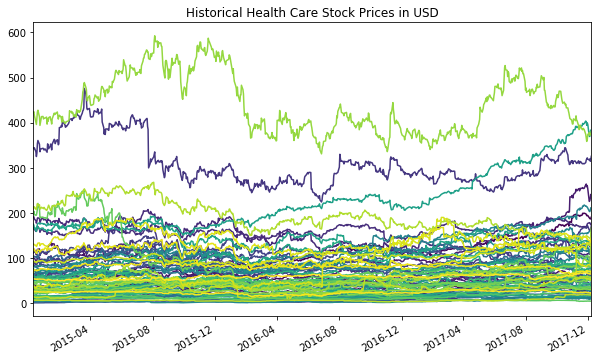

In [14]:
closeP.plot(figsize = (10, 6),
            title = "Historical Health Care Stock Prices in USD", 
            legend=False, colormap= 'viridis')

As we can see, the graph of the original Times Series is too crowded to sucessfully analyze the information and select the trading pairs.

We would need to take a systematic approach to identify which Time Series in this universe move closely together (if any!).

<center> <h3> Identify Stock Pairs </h3> <center>


Identification of Stock Pairs could be done using a variety of approaches.
In this project we will use **correlation** approach to systematically select th pairs with the highest pairwise correlations.

It is crucial to note that the time series of prices exhibit **non-stationary behaviour**. It happens, as prices themselves follow a **randow walk**, which is a stochastic process whose variance is not limited (in theory). 


As a consequence of unbounded variance, the randow walk does not exhibit the **mean-reverting** behavior, which is the basis of the majority of the trading strategies and time series analysis.  


However, this problem can be resolved using such approaches as differencing. In our case we would use the **log-returns** as a selected diffencing approach. We use log-returns, as we assume that the prices follow the **log-normal distribution**. 


First, we calculate the daily log returns by first converting every Closing Prices time series to log scale and then taking the difference. 

Note, that the row corresponding to the oldest date will have NaN-s, which results from return clauclations - so we drop it.

In [22]:
log_ret = np.log(closeP).diff() # log-return calculation
log_ret.dropna(axis=0, how='all', inplace = True) # drop the rows that contain only NaN values


In [23]:
pairs_num = (closeP.shape[1]*(closeP.shape[1]-1))/2
print("Currently there are "+ str(pairs_num) + " possible trading pairs.")

Currently there are 2926.0 possible trading pairs.


First, we would proceed to create a matrix of correlations that each of pair of Health Care stocks has during the sample period of **December 10th 2014 through December 10th 2017**.

In [24]:
log_ret_corrP = log_ret.corr(method='pearson')
log_ret_corrP.head(3)

,ABMD,ACAD,ACHC,AERI,AGIO,AKRX,ALGN,ALKS,ALNY,ALXN,...,SHPG,SPPI,SRPT,TECH,TSRO,UTHR,VRTX,WBA,WMGI,XRAY
ABMD,1.00000,0.220670,0.241660,0.194544,0.184449,0.226065,0.292829,0.202901,0.179449,0.176041,...,0.215514,0.185497,0.119922,0.236223,0.200454,0.158605,0.183318,0.183456,0.226590,0.210036
ACAD,0.22067,1.000000,0.321775,0.232351,0.500997,0.334873,0.271314,0.410938,0.437271,0.412901,...,0.354659,0.332008,0.221024,0.302711,0.358141,0.397983,0.442995,0.212124,0.283828,0.195244
ACHC,0.24166,0.321775,1.000000,0.144338,0.267195,0.309344,0.350660,0.245494,0.245756,0.275330,...,0.307770,0.162673,0.114183,0.292396,0.245311,0.249340,0.309779,0.189448,0.265086,0.272052


Next, we would need to sort through this matrix to identify the pairs that exhibit the highest correlations:

To accomplish that, first we need to drop the repeatead values and create an upper triangular matrix.
Then, as each stock has a correlation of **1** with itself, we replace all diagonal values with zeros. 

Now, we can create a list of tuples with correlation values and corresponding positions that we can sort through and find ** top 3** most correlated pairs.

In [25]:
corr_lower = np.triu(log_ret_corrP) # create upper triangular matrix
np.fill_diagonal(corr_lower, 0) # replace the correlations on diagonal with 1-s


logR_corr_lower = pd.DataFrame(corr_lower) 

logR_corr_lower.set_index(log_ret_corrP.index.values, inplace = True)
logR_corr_lower.columns = log_ret_corrP.columns.values # reset column names back to original
logR_corr_lower.to_csv("mainnewcorr.csv")

In [214]:
positions = []
shape = logR_corr_lower.shape
for i in range(0, shape[0]): 
    for j in range(i, shape[1]): # use nested loop to iterate through "locations"
        positions.append((logR_corr_lower.iloc[i, j], (i,j)))

max_corr = sorted(positions, key=lambda x: -x[0])

# Lambda sorts the list (positions) of correlations and indexes based on first entry, 
# which is the the correlation 

In [216]:
print(max_corr[0][0])
print(logR_corr_lower.columns[max_corr[0][1][0]], "has a large correlation with ", logR_corr_lower.columns[max_corr[0][1][1]], 
     "with a value of", max_corr[0])

0.663747349195
AMGN has a large correlation with  CELG with a value of (0.66374734919514555, (10, 16))


Additionally, we could also take a look at the top 10 highest correlations to see how much higher the correlation between our selected CELG and AMGN pair is:

In [219]:
print("The top 10 correlations are: \n", [x[0] for x in max_corr[:10]])

The top 10 correlations are: 
 [0.66374734919514555, 0.62227510119287555, 0.61031004011297796, 0.60075091618774235, 0.5659278932285382, 0.56338788476594193, 0.56337351062796404, 0.56228953095147682, 0.55974097015709667, 0.5568316099641446]


<center > <h3>  Examine the Pairs Trade  </h3> <center>



Now that the pairs are chosen, we will examine their time series.

Taking a quick look at the Closing Price movements for AMGN and CELG, we can capture with our own bare eye that the moves were relatively correlated.

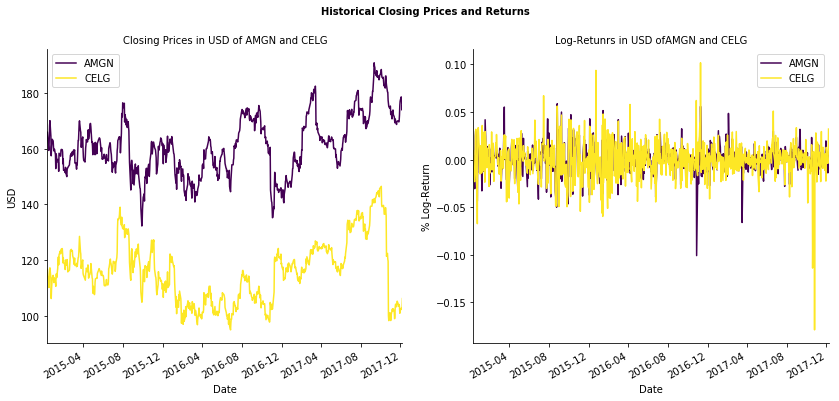

In [61]:
pair1 = ['AMGN', 'CELG']
logr_pair1 = log_ret[pair1] # define series for log returns for pair 1


fig, ax = plt.subplots(nrows = 1, ncols = 2, sharex = True, figsize = (14,6)) 

closeP[pair1].plot(ax = ax[0], colormap = 'viridis') # Closing Prices 
logr_pair1.plot(ax = ax[1], colormap = 'viridis') # Log Returns


fig.suptitle("Historical Closing Prices and Returns", fontsize = 10, fontweight = "bold")

ax[0].set_title(str("Closing Prices in USD of " + str(pair1[0]) + " and " + str(pair1[1])), fontsize = 10)
ax[0].set_ylabel("USD") 


ax[1].set_title(str("Log-Retunrs in USD of" + str(pair1[0]) + " and " + str(pair1[1])), fontsize = 10)
ax[1].set_ylabel("% Log-Return") 


for var in ax:     
    var.set_xlabel("Date") # set the x label to Date
    var.spines["right"].set_visible(False) # remove the top and right spines 
    var.spines["top"].set_visible(False)
    

plt.show()


The actual correlations between the log-returns are:

In [62]:
pair1_corr = logr_pair1.corr(method='pearson') # get a correlation dataframe (4x4 matrix)

# select the non-diagonal entry in this dataframe to get the correlation
print("Correlation between " + str(pair1[0])+ " and "+ str(pair1[1])+ " is " + 
      str(pair1_corr.iloc[0,1])) 


Correlation between AMGN and CELG is 0.663747349195


Next, we are interested in looking at the spread between these stocks.
For that, we will be using the original Time Series of the Closing Prices.

First, we run a simple list squares regression and define the difference between the prices. Given this regression, we will get the **Beta**, which will be the hedge ratio between the two stocks. 

That means that we are going to use a **beta-neutral** instead of a dollar-neutral hedge strategy, which will allow the portfolio to stay market-neutral. 


In [109]:
# define the dataframe of the closing prices of our pair
pair1_closeP = np.diff(np.log(closeP[pair1].values.T))


Thus, we will run the regression AMGN (x) and CELG (y), as we are looking for the **“Pairs Portfolio”**.

In [111]:
# 0: AMGN, 1: CELG
from sklearn.linear_model import LinearRegression

# we now define a linear regression, and run it over the pair 
lm = LinearRegression()
amgn, celg = pair1_closeP
lm.fit(amgn.reshape(-1, 1), celg)


print("Beta:" ,lm.coef_[0])
beta = lm.coef_[0]

Beta: 0.870142488065


Now we are looking to examine the **simple** and **cumulative** (compounded) log-returns for the following portfolio:

<center> <h4> CELG – AMGN*Beta </h4></center>
<center> <h4>Long CELG and short AMGN*Beta </h4></center>



In this example, when constructing the  **Pairs Portfolio**, we would assume that the **risk-free rate is zero** and we are not reinvesting the cash proceeds from the short sale back into the market or the risk free rate. We also do not earn any interest on the margin account. 

While it is slightly unrealistic, it will slightly offset the **T-costs** consideration that we are not incorporating.


In [184]:
# Now define the pairs portfolio
pairs_portfolio = celg - amgn*beta

#pp_cum_returns = (pairs_portfolio + 1).cumprod() - 1
pp_cum_returns = np.exp(pairs_portfolio.cumsum()) -1

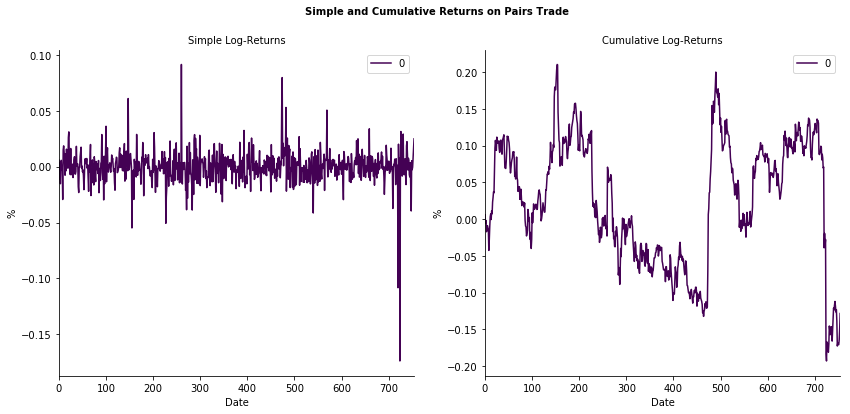

In [185]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, sharex = True, figsize = (14,6)) 

pd.DataFrame(pairs_portfolio).plot(ax = ax[0], colormap = 'viridis') # Log-terunrs 
pd.DataFrame(pp_cum_returns).plot(ax = ax[1], colormap = 'viridis') # Cumulative log-returns


fig.suptitle("Simple and Cumulative Returns on Pairs Trade", fontsize = 10, fontweight = "bold")

ax[0].set_title("Simple Log-Returns", fontsize = 10)
ax[0].set_ylabel("%") 

ax[1].set_title(str("Cumulative Log-Returns"), fontsize = 10)
ax[1].set_ylabel("%") 


for var in ax:     
    var.set_xlabel("Date") # set the x label to Date
    var.spines["right"].set_visible(False) # remove the top and right spines 
    var.spines["top"].set_visible(False)

We can see that recently there was a major drawdown in the performance of this startegy. If we look back at the time series we will notice that **CELG** has experienced a major Price drop. 

However, that is exactly what we are looking for, as we are looking for the weakening in correlation to enter into this tartegy and go long the underperforming stock CELG and long the overperfroming stock AMGN.

Now we would look at the simple log-return of our Pairs portfolio and compare it to the simple log-return on CELG and AMGN.

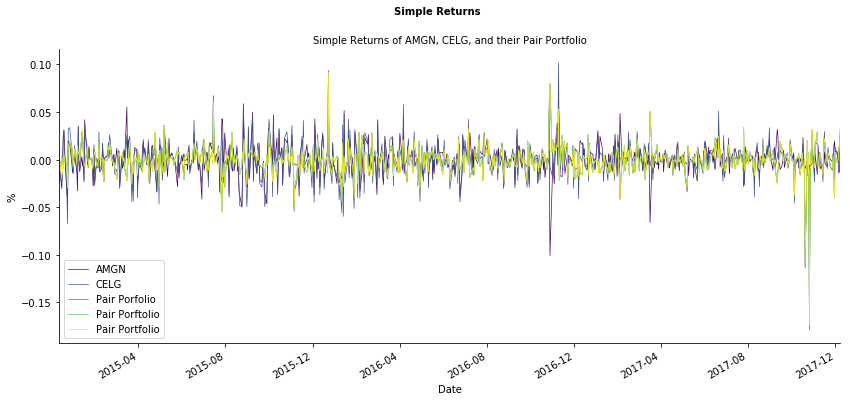

In [204]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, sharex = True, figsize = (14,6)) 


logr_pair1["Pair Portfolio"] = pairs_portfolio


logr_pair1.plot(ax = ax, colormap = 'viridis', linewidth=.67) # Closing Prices 


fig.suptitle("Simple Returns", fontsize = 10, fontweight = "bold")

ax.set_title("Simple Returns of AMGN, CELG, and their Pair Portfolio", fontsize = 10)
ax.set_ylabel("%") 



for var in [ax]:     
    var.set_xlabel("Date") # set the x label to Date
    var.spines["right"].set_visible(False) # remove the top and right spines 
    var.spines["top"].set_visible(False)
    

plt.show()

In [205]:
logr_pair1.describe()

,AMGN,CELG,Pair Porfolio,Pair Porftolio,Pair Portfolio
count,755.000000,755.000000,755.000000,755.000000,755.000000
mean,0.000078,-0.000114,-0.000182,-0.000182,-0.000182
std,0.015349,0.020122,0.015050,0.015050,0.015050
min,-0.100756,-0.178748,-0.173931,-0.173931,-0.173931
25%,-0.007627,-0.009583,-0.006725,-0.006725,-0.006725
50%,0.000457,0.000558,0.000136,0.000136,0.000136
75%,0.007983,0.010353,0.006471,0.006471,0.006471
max,0.058779,0.101786,0.091555,0.091555,0.091555


We can notice that the standard deviation of our portfolio is slightly lower than each individual stdev of AMGN and CELG.

Yet the mean return on the Pairs Portfolio is also lower, which has been primarily cause by the recent drop in CELG's value.

At teh same time we can identify the the return distribution of the Pairs Portfolio is slightly more **positively skewed** compared to the distributions of log-returns on teh individual stocks. (As the left tail (25th%) is shorter for portfolio than for individual stocks).

In [209]:
pcnt_beat_amgn = sum(logr_pair1["Pair Portfolio"] >= logr_pair1["AMGN"]) / logr_pair1.shape[0]
pcnt_beat_celg = sum(logr_pair1["Pair Portfolio"] >= logr_pair1["CELG"]) / logr_pair1.shape[0]
print("Percentage time our returns exceed AMGN is:", pcnt_beat_amgn)
print("Percentage time our returns exceed CELG is:", pcnt_beat_celg)

Percentage time our returns exceed AMGN is: 0.498013245033
Percentage time our returns exceed CELG is: 0.476821192053


**At the same time, by selecting this *Pairs Portfolio* at each individual day over individual stock of CELG or AMGN is alomst like flipping a coin, even slightly worse.**



Yet it relates to the returns on individual days - this is why we will proceed to look at the **cumulative realized returns**.

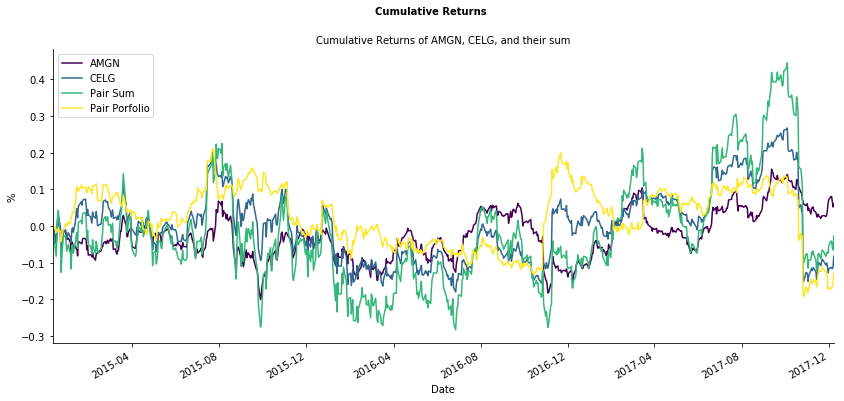

In [187]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, sharex = True, figsize = (14,6)) 

logr_pair1["Pair Sum"] = (logr_pair1.sum(axis=1))
logr_pair1["Pair Porfolio"] = pairs_portfolio

#pair1_cum = (logr_pair1 + 1).cumprod(0) - 1
pair1_cum = np.exp(logr_pair1.cumsum()) - 1



pair1_cum.plot(ax = ax, colormap = 'viridis') # Closing Prices 


fig.suptitle("Cumulative Returns", fontsize = 10, fontweight = "bold")

ax.set_title("Cumulative Returns of AMGN, CELG, and their sum", fontsize = 10)
ax.set_ylabel("%") 



for var in [ax]:     
    var.set_xlabel("Date") # set the x label to Date
    var.spines["right"].set_visible(False) # remove the top and right spines 
    var.spines["top"].set_visible(False)
    

plt.show()

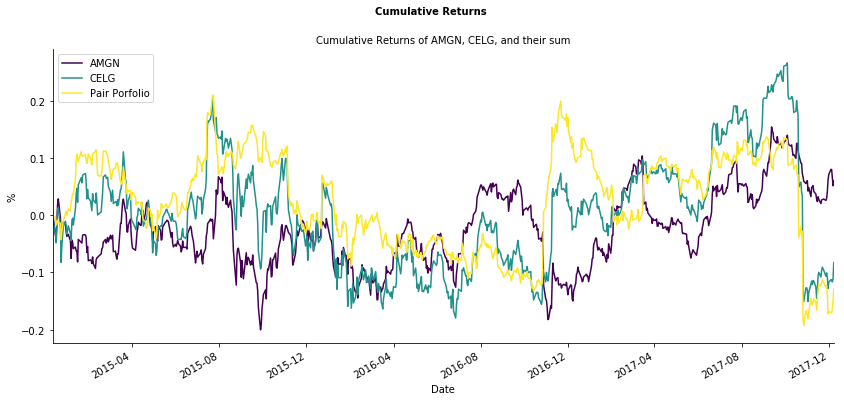

In [192]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, sharex = True, figsize = (14,6)) 

pair1_cum_nosum = pair1_cum[['AMGN', 'CELG', 'Pair Porfolio']]



pair1_cum_nosum.plot(ax = ax, colormap = 'viridis') # Closing Prices 


fig.suptitle("Cumulative Returns", fontsize = 10, fontweight = "bold")

ax.set_title("Cumulative Returns of AMGN, CELG, and their sum", fontsize = 10)
ax.set_ylabel("%") 



for var in [ax]:     
    var.set_xlabel("Date") # set the x label to Date
    var.spines["right"].set_visible(False) # remove the top and right spines 
    var.spines["top"].set_visible(False)
    

plt.show()

### Cumulative Return Analysis and Summary

Adter Taking a look at the graphs of **cumulative simple realized returns** we can see that there are multiple period when teh portfolio has been outperforming teh individual CELG and AMGN stocks as well as the combination of long AMGN and long CELG stocks.

For instance, the periods from approximately **December 2014 to June 2016** and **December 2016 to March 2017**, the Pairs Portfolio cumulatibely yielded its best returns. 

Yet as expected in the recent period around **November 2017 to December 2017**, the portfolio has been underperforming its individual holdings.
It hapened because we were long the stock that has dropped in value significantly, while we were short the one that has slightly increased in value.

This is exactly when the correlation pattern has broken down - and exactly what we have been looking for: the opportunity to put on the trade.

The rationale to invest in this strategy would come from the fact that these stocks **move up or down with approximately similar magnitude**. We would expect that to continue in the future and thus should take advanatge of the opportunity to **buy the relatively cheap stock CELG and sell the relatively expensive stock AMGN**. 

As a final note, this notebook can be used to analyse sectors beyond the **Health Care** and screen for the *highest-correlation stocks* in order to identify the best-perfroming pairs selection to implement as a *market-neutral* (beta-hedged) pairs trade. 


Sabina Lenskaya

Sources:
Pairs Trading Quantitative Methods and Analysis GANAPATHY VIDYAMURTHY

https://github.com/alfranz/python-pairs-trading/blob/master/pairs-trade.py

https://datacrushblog.wordpress.com/2016/12/20/statistical-arbitrage-trading-pairs-in-python-using-correlation-cointegration-and-the-engle-granger-approach/


https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing
